In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [1]:
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax.scipy.stats import norm
from jax import grad, jit, vmap
from jax import random as jrandom
import jax

from jax import config
config.update("jax_enable_x64", True)

from typing import Sequence, Tuple, Union, Optional
from jaxtyping import Array, ArrayLike, Float, Int, PyTree, PRNGKeyArray, ScalarLike

import equinox as eqx
import optax
import chex

import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

from dataclasses import dataclass, astuple
from functools import partial

import numpy as np

jax.enable_checks = True

jax.devices()

2023-09-06 15:13:56.531496: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-06 15:13:57.263458: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[gpu(id=0)]

# Payoff

In [2]:
class EuropeanPayoff:
    @staticmethod
    def call(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        return jnp.maximum(jnp.subtract(maturity_prices, strike_prices), 0.0)

    @staticmethod
    def put(maturity_prices: Float[ArrayLike, " n"], strike_prices: Float[ScalarLike, ""]) -> Float[Array, " n"]:
        return jnp.maximum(jnp.subtract(strike_prices, maturity_prices), 0.0)

    @staticmethod
    def payoff(spot_path, K, payoff_fn = call):
        spot_maturity = spot_path[..., -1]
        payoff = payoff_fn(spot_maturity, K)
        return payoff


def european_payoff(spot_path, K, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[..., -1]
    payoff = payoff_fn(spot_maturity, K)
    return payoff

def european_payoff_and_deriv(spot_path, K, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[..., -1]
    # payoff = payoff_fn(spot_maturity, K)
    payoff, dpayoff = jax.value_and_grad(payoff_fn)(spot_maturity, K)
    return payoff, dpayoff

# Smoothing

## test sequence

31.60696125855624


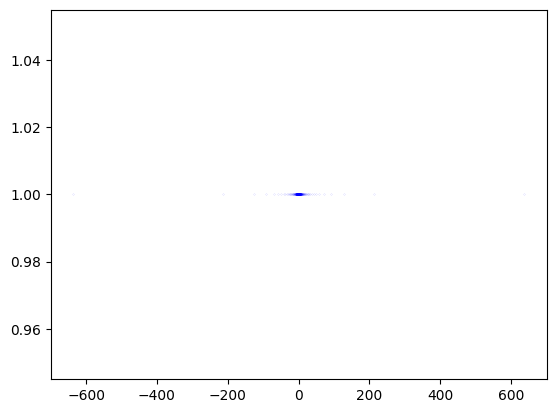

In [3]:
def chebyshev_sequence(n):
    # Generate Chebyshev nodes in the interval [-1, 1]
    k = np.arange(1, n + 1)
    nodes = np.tan((2 * k - 1) * np.pi / (2 * n))
    return nodes

# Number of points in the sequence
n = 1000  # Adjust as needed

# Generate the Chebyshev sequence
sequence = chebyshev_sequence(n)
print(jnp.std(sequence))
plt.plot(sequence, jnp.ones(n), 'b.', markersize=0.1)

## sigmoidal smoothing

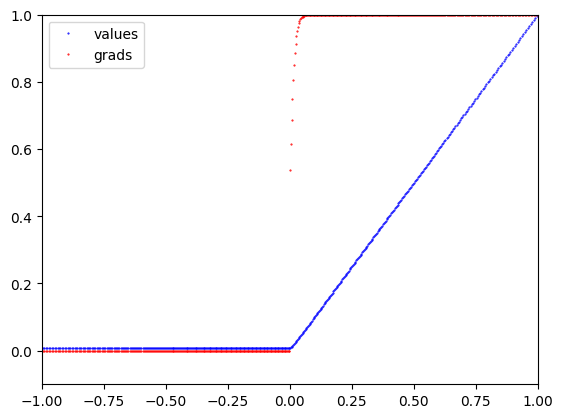

In [5]:
def sigmoidal_smoothing(f, k=100):

    def smooth_f(*args):
        return 1/k * jnp.log(1 + jnp.exp(k * f(*args)))

    return smooth_f

smooth_max = sigmoidal_smoothing(lambda x: jnp.maximum(0.0, x))

xs = sequence
ys_true = jnp.maximum(0.0, xs)
# print("xs", xs)
# print("ys_true", ys_true)

ys, dys = jax.vmap(jax.value_and_grad(smooth_max))(xs)
# ys = smooth_max(xs)

# print("ys_smooth", ys)
# print("ys_error", ys-ys_true)
plt.plot(xs, ys, 'b.', markersize=1.0, label="values")
plt.plot(xs, dys, 'r.', markersize=1.0, label="grads")
plt.legend()
plt.xlim([-1e0, 1e0])
plt.ylim([-0.1, 1])
plt.show()

## cubic spline smoothing

ys_error 0.0003179521269595528


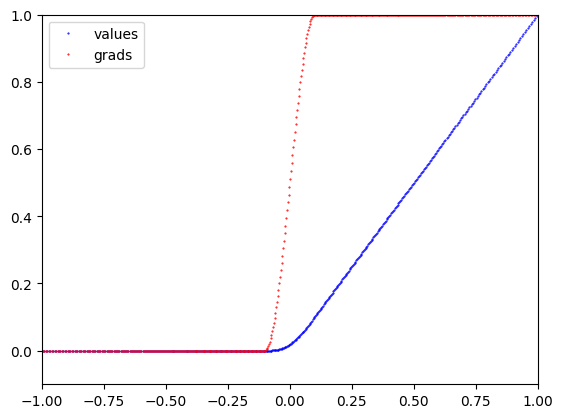

In [4]:
# cubic spline smoothing from:
# https://link.springer.com/article/10.1007/s00780-009-0097-9

def cubic_spline_smoothing(f, k=.1):
    @jit
    def smooth_f(x):
        i = jnp.argwhere(jnp.array([x < -k, x <= k, True]), size=1).squeeze()
        below = lambda x: jnp.zeros_like(x)
        poly = lambda x: -1/(16*(k**3)) * x**4 + 3/(8*k) * x**2 + .5*x + (3*k)/16
        above = lambda x: x
        return jax.lax.switch(i, [below, poly, above], x)

    return smooth_f


smooth_max_cubic = cubic_spline_smoothing(partial(jnp.maximum, 0.0))

xs = sequence
ys_true = jnp.maximum(0.0, xs)
# print("xs", xs)
# print("ys_true", ys_true)

ys, dys = jax.vmap(jax.value_and_grad(smooth_max_cubic))(xs)
# ys = vmap(smooth_max_cubic)(xs)

# print("ys_smooth", ys)
print("ys_error", jnp.mean(ys-ys_true))
plt.plot(xs, ys, 'b.', markersize=1.0, label="values")
plt.plot(xs, dys, 'r.', markersize=1.0, label="grads")
plt.legend()
plt.xlim([-1e0, 1e0])
plt.ylim([-0.1, 1])
plt.show()

# Heston

In [5]:

    
class ModelState(eqx.Module):
    S0: float
    v0: float

class Heston(eqx.Module):

    # S0: float = 100.0       # Initial spot price
    # K: float = 100.0        # Strike price
    # r: float = 0.0319       # Risk-free rate
    # v0: float = 0.010201    # Initial volatility
    # T: float = 1.00         # One year until expiry
    # rho: float = -0.7       # Correlation of asset and volatility
    # kappa: float = 6.21     # Mean-reversion rate
    # theta: float = 0.019    # Long run average volatility
    # xi: float = 0.61        # Volatility of volatility

    # European call option price is at 34.99 for the following config: 
    S0: float = 100.0       # Initial spot price
    K: float = 100.0        # Strike price
    r: float = 0.05         # Risk-free rate
    v0: float = 0.09        # Initial volatility
    T: float = 5.00         # n years until expiry, i.e. T2 - T1
    rho: float = -0.3       # Correlation of asset and volatility
    kappa: float = 2.00     # Mean-reversion rate
    theta: float = 0.09     # Long run average volatility
    xi: float = 1.00        # Volatility of volatility

    @property
    def model_state(self) -> ModelState:
        return ModelState(self.S0, self.v0)

def volatility_path(v0, vol_draws, self):
    n_iter = len(vol_draws)
    dt = self.T / n_iter

    def vol_path_iter(prev_vol_path, vol_draw):
        # v_truncated = jnp.maximum(0.0, prev_vol_path) # TODO: Needs smoothing!
        v_truncated = smooth_max_cubic(prev_vol_path)
        prev_path_contribution = prev_vol_path + self.kappa * dt * (self.theta - v_truncated)
        randomness = self.xi * jnp.sqrt(v_truncated * dt) * vol_draw
        current = prev_path_contribution + randomness
        return current, current # use current both for carry and for y

    carry, vol_path = jax.lax.scan(vol_path_iter, jnp.array(self.v0), vol_draws, length=n_iter)
    # jax.debug.print("vol_path {}", vol_path.shape)
    
    # we now have iteration 1 at position 0. Place initial v0 at the end and rotate into initial slot
    vol_path = jnp.roll(vol_path.at[-1].set(v0), 1)
    return vol_path


def spot_path(S0, self, spot_draws: Array, vol_path: Array) -> Array:
    n_iter = len(spot_draws)
    dt = self.T / n_iter

    def spot_path_iter(prev_spot_path, iter_pair):
        spot_draw = iter_pair[0]
        vol = iter_pair[1]
        # v_truncated = jnp.maximum(0.0, vol)
        v_truncated = smooth_max_cubic(vol)
        path_new_spot = prev_spot_path * jnp.exp((self.r - 0.5 * v_truncated) * dt + jnp.sqrt(v_truncated * dt) * spot_draw)
        return path_new_spot, path_new_spot

    iter_values = jnp.column_stack((spot_draws, vol_path))
    carry, spot_paths = jax.lax.scan(spot_path_iter, jnp.array(S0), iter_values, length=n_iter)
    # jax.debug.print("spot paths: {}", spot_paths)
    
    spot_paths = jnp.roll(spot_paths.at[-1].set(S0), 1)
    return spot_paths


def model_state_path(state: ModelState, self, vol_draws, spot_draws):
    vol_path = volatility_path(state.v0, vol_draws, self)
    s_path = spot_path(state.S0, self, spot_draws, vol_path)
    return s_path

def payoff(self, spot_path, payoff_fn = EuropeanPayoff.call):
    spot_maturity = spot_path[-1]
    payoff = payoff_fn(spot_maturity, self.K)
    return payoff

def path_and_payoff(state: ModelState, self, vol_draws, spot_draws):
    return payoff(self, model_state_path(state, self, vol_draws, spot_draws))

def correlated_draws(self: Heston, key, n_samples):
    mean = jnp.zeros(2)
    cov = jnp.array([[1.0, self.rho], [self.rho, 1.0]])

    correlated_samples = jrandom.multivariate_normal(key, mean, cov, shape=(n_samples,))

    vol_draws = correlated_samples[:, 0]
    spot_draws = correlated_samples[:, 1]
    return vol_draws, spot_draws

def path_fn(self: Heston, key: PRNGKeyArray, n_time_steps: int = 1000):
    # jax.debug.print("hest spots: {}", self.S0.shape)
    # jax.debug.print("hest vols: {}", self.v0.shape)
    # jax.debug.print("corr draws key: {}", key.shape)
    vol_draws, spot_draws = correlated_draws(self, key, n_time_steps)
    return path_and_payoff(self.model_state, self, vol_draws, spot_draws)

def differential_path(self: Heston, key: PRNGKeyArray, n_intervals: int = 1000):
    vol_draws, spot_draws = correlated_draws(self, key, n_intervals)
    p, dp = jax.value_and_grad(path_and_payoff)(self.model_state, self, vol_draws, spot_draws)
    return p, dp


In [6]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
key, key_spots, key_vols = jrandom.split(subkey, 3)
n_samples = 100

initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
# initial_spots = jnp.ones((n_samples)) * 100
# initial_vols = jnp.ones((n_samples)) * 0.09
h = Heston(S0=initial_spots, v0=initial_vols)
print(h)

Heston(
  S0=f64[100],
  K=100.0,
  r=0.05,
  v0=f64[100],
  T=5.0,
  rho=-0.3,
  kappa=2.0,
  theta=0.09,
  xi=1.0
)


# Skip


In [41]:
def heston_taker(h: Heston):
    rng = jrandom.PRNGKey(0)
    return path_fn(h, rng)

In [44]:
res = eqx.filter_vmap(heston_taker)(h)
print(res.shape)

(100,)


In [49]:
key, subkey = jrandom.split(key)
n_sims = 100

keys = jrandom.split(subkey, n_sims)
# keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
print(len(keys))
print(keys.shape)

# res = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)

# payoffs = eqx.filter_vmap(path_fn)(h, keys)

#payoffs = jax.vmap(eqx.filter_vmap(path_fn), in_axes=(None, 0))#(h, keys)
# payoffs = eqx.filter_vmap(eqx.filter_vmap(path_fn), in_axes=(None, 0))
# payoffs = eqx.filter_vmap(eqx.filter_vmap(path_fn), in_axes=(None, 0))

payoffs = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)

print(payoffs)

# payoffs(h, keys)

# option_price = jnp.mean(payoffs, axis=0) * jnp.exp(-h.r * h.T)
# print(option_price.shape)
# print(option_price)


100
(100, 2)


ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * most axes (2 of them) had size 100, e.g. axis 0 of argument _dynamic_args[0].S0 of type float64[100];
  * one axis had size 2: axis 0 of argument _dynamic_args[1] of type uint32[2]

In [87]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
n_sims = 10000

keys = jrandom.split(subkey, n_sims)
keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
print(len(keys))
print(keys.shape)

@jit
def option_price(h, keys):
    return jax.vmap(lambda k: eqx.filter_vmap(path_fn)(h, k))(keys)

def inner(h, k):
    res =  eqx.filter_vmap(path_fn)(h, k)
    print(res.shape)
    return res

#payoffs = jit(eqx.filter_vmap(partial(inner, h)))(keys) 
# res = option_price(h, keys)
payoffs = jax.vmap(lambda k: eqx.filter_vmap(path_fn)(h, k))(keys)
print(payoffs.shape)

# print(jnp.mean(res, axis=))
res = jnp.mean(payoffs, axis=0) * jnp.exp(-h.r * h.T)
print(res.shape)
print(res)


100
(100, 100, 2)
(100, 100)
(100,)
[26.14491736 47.23131959 29.84869553 38.08491958 33.03175936 30.21266902
 45.32301449 29.57048105 29.12291798 38.80504425 28.74904231 44.34363942
 31.97764956 32.48644494 39.28660562 42.63461245 35.53501534 54.10339934
 29.73836971 36.60067229 30.64719171 42.87891537 31.26578682 32.52510219
 34.90138395 44.08203845 31.12473287 35.18247349 39.5635788  38.9764712
 34.91492871 39.47289014 32.0727956  38.38633496 36.45425844 27.03558845
 31.91317162 42.50553563 34.67368298 33.50347796 36.32732915 39.59144137
 30.44176324 43.24410894 34.4963725  36.53700132 41.0167225  43.14132888
 40.03842159 33.92170827 43.44642325 23.68690673 31.93230527 33.60740013
 37.28394061 30.35718126 28.81876953 25.79701643 39.95621617 39.89883314
 36.34715449 36.98098142 33.56967079 29.75416847 46.86846385 41.37028599
 26.46462299 40.02382461 33.71580829 34.3566919  32.85867373 31.73014088
 35.44360501 29.51898512 34.58775278 42.1265726  30.20014292 37.6303917
 36.41752535 23.9

# Skip End

In [7]:
# the keys should be vmaped over in the inner loop

key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)

# keys = jrandom.split(subkey, n_sims)
# keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
# print(keys.shape)

@eqx.filter_jit
def inner(h, k, n_sims=100):

    # jax.debug.print("k.shape {}", k.shape)
    keys = jrandom.split(k, n_sims)
    res_fn = eqx.filter_vmap(path_fn, in_axes=(None, 0))
    # res = res_fn(h, keys)
    # print("inner: ", res.shape)
    res = jnp.sum(res_fn(h, keys))
    return res

print(inner)

@eqx.filter_jit
def option_price(key, h: Heston, n_sims=100):
    print(n_sims)
    payoffs_fn = eqx.filter_vmap(partial(inner, n_sims=n_sims))
    
    keys = jrandom.split(key, n_samples)
    # payoffs = payoffs_fn(h, keys) 
    price = jnp.divide(payoffs_fn(h, keys), n_sims) * jnp.exp(-h.r * h.T)
    return price
    # print(option_price)


# payoffs = eqx.filter_vmap(inner)(h, keys)

# res = option_price(h, keys)
# payoffs = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(x, keys))(h)
# print(payoffs.shape)
# print(payoffs)

# res = jnp.mean(payoffs, axis=0) * jnp.exp(-h.r * h.T)
# print(res.shape)
# print(res)

_JitWrapper(
  _signature=<Signature (h, k, n_sims=100)>,
  _dynamic_fun=(None,),
  _static_fun=((<function inner>,), PyTreeDef(*)),
  _cached=<wrapped function inner>,
  _filter_warning=False
)


In [8]:
key = jrandom.PRNGKey(14)
key, subkey = jrandom.split(key)
p = option_price(subkey, h, n_sims=1000)
print(p)


1000
[54.24157691 12.94686957 59.86306187 28.63533819  7.39374319 12.6514746
 19.29293047 15.85173869 10.1520953  67.3061614  23.31149666  9.20426421
 27.7788229  82.25154949 45.69504321 21.18373614 70.42659788 12.01370339
  8.4347048  25.81190391  5.32009627 22.3655783  79.3711026   4.91207507
 80.55992282 41.86696341 64.96343191 62.99003994 29.74500122  5.93170364
 44.7833568  48.23398428 73.87261988 19.37181812 80.06639393 69.9589764
 24.96250614 76.56483016 15.28952681 36.11815652 75.75998417 29.95715707
 51.84724068 16.71859605 85.98761356 26.04423583 11.99347278 30.76048401
 29.8701894  63.11442547 14.69068453  5.14725043 20.94030122 50.09495621
 19.73331272 42.8566979  49.0736291  10.25504153  5.58062171 58.86212553
 30.21081137 68.94838767 39.89832712 46.09815798 75.95616596 10.23369893
 59.30732679 13.3550106  65.25232352 64.86780453 47.24385118 36.57810864
 42.40629466 66.42281786 21.36124473 11.66617914 17.45802314 36.38761945
 62.98196001 70.01742101 33.65366681 60.42792425

In [11]:
key = jrandom.PRNGKey(14)
key, subkey = jrandom.split(key)
n_sims = 10000

keys = jrandom.split(subkey, n_sims)
keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
print(len(keys))
print(keys.shape)


# def map_reduce(payoff_sum, key):
#     # print("inner keys shape:", key.shape)

#     keys = jrandom.split(key, n_samples)
#     # res = eqx.filter_vmap(path_fn)(h, keys)
#     res = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)
#     print("inner shape:", res.shape)


#     payoff_sum_iter = jnp.sum(res)
#     # jax.debug.print("payoff sum iter {}", payoff_sum_iter)
#     payoff_sum += payoff_sum_iter
#     return payoff_sum, None


# res, _ = jax.lax.scan(map_reduce, jnp.zeros(n_samples), keys)

# res = jax.vmap(map_reduce)(keys)
# res = jax.vmap(lambda hes: jnp.sum(eqx.filter_vmap(path_fn)(
# res /= n_samples
# res *= jnp.exp(-h.r * h.T)
# res = jnp.reshape(res, n_sims)

res = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)
res = jnp.mean(res, axis=0) * jnp.exp(-h.r * h.T)
print(res.shape)
print(res)

@eqx.filter_jit
def option_price2(key, h: Heston, n_sims=100):
    n_samples = h.S0.shape[0]
    # print(n_samples)
    keys = jrandom.split(key, n_sims)
    keys = jnp.reshape(keys, (n_sims//n_samples, n_samples, 2))
    
    payoffs = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(h, x))(keys)
    price = jnp.mean(payoffs, axis=0) * jnp.exp(-h.r * h.T)
    return price


@eqx.filter_jit
def option_price_scalar(h: Heston, key, n_paths=1000):
    keys = jrandom.split(key, n_paths)
    payoffs = eqx.filter_vmap(path_fn, in_axes=(None, 0))(h, keys)
    price = jnp.mean(payoffs) * jnp.exp(-h.r * h.T)

    return price

def option_greeks_scalar(h: Heston, key, n_paths=10000):
    price, greeks = eqx.filter_value_and_grad(option_price_scalar)(h, key, n_paths)
    return price, greeks
# prices = price(subkey, h)
# jax.debug.print("prices {}", prices)

100
(100, 100, 2)
(100,)
[61.58777415  9.37350307 58.52063123 27.34416096  7.49443646  6.69828086
 22.3864475   9.93067342 10.72249223 72.50299501 20.93952465 12.59570677
 18.74552543 67.94257108 48.80812542 27.75589921 60.50381523 15.2521504
  5.47679753 30.29752901  5.54838469 15.34029215 73.86287866  3.47075934
 91.38109014 43.00097576 63.07191976 78.605772   30.25456529  7.48332097
 47.81454641 48.25017553 78.63943567 19.95489488 79.13029999 70.28161186
 19.84585952 93.59411188 13.0854812  44.06838027 76.83591253 31.98798023
 61.66932166 15.76958315 88.37743171 21.8379111  11.12132505 22.03941461
 33.3262024  65.57427789 11.66125778  7.08863588 18.31467369 44.38851382
 18.53683243 50.93297196 60.82149048 10.57894732  5.30385116 72.54802766
 38.22441672 75.2113746  38.15005626 46.18890361 67.82830177  9.77504186
 73.40181428  9.0136984  48.60406466 58.21323431 52.05005003 32.77961212
 44.10703549 80.11834271 17.55163678 13.65901455 17.29307845 32.22666696
 46.19523585 80.12906597 33

In [12]:
# key = jrandom.PRNGKey(14)
key, subkey = jrandom.split(key)
p = option_price2(subkey, h, n_sims=100000)
print(p)
print(jnp.mean(p))

[53.88042473 13.68406931 53.76581221 26.90959827  9.22582708  8.8168295
 20.30957575 15.68915178 10.38557708 63.69905859 23.05418633  8.32721026
 26.75117518 82.05917374 43.80888808 22.67222351 66.44131631 11.66614946
  9.64560357 30.60903886  5.38592121 24.80294234 77.9832899   4.43885123
 81.25760396 43.62088564 60.89333296 67.59362463 32.60267905  7.41270625
 47.88691726 43.55647859 77.61067375 17.65118904 77.46097991 70.41220279
 22.52709528 78.70435496 18.69101989 36.84436058 71.74456627 29.53341996
 54.68015239 18.26478129 72.94837286 22.7560673  12.5080296  29.0751175
 31.04643488 61.30218679 13.01573047  4.51268804 23.15078243 50.7852673
 19.87359686 45.55086162 50.55255102  9.15255811  5.06911477 57.21487397
 33.31814212 74.04697846 43.2754812  43.90365325 70.43685485 10.02260127
 59.73318946 13.53345067 61.65936873 68.53079058 46.99548551 32.01283031
 42.29553468 71.11156029 18.77283045 10.10265643 19.06209891 41.64004641
 58.23632655 67.9658048  31.88844067 56.25704021 14.66

# Test scenarios

from:
https://www.researchgate.net/publication/220243902_Exact_Simulation_of_Stochastic_Volatility_and_Other_Affine_Jump_Diffusion_Processes

and: 
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1718102


In [14]:
def mse(y_pred, y_true):
    return jnp.mean((jnp.array(y_pred) - jnp.array(y_true))**2)

def rmse(y_pred, y_true):
    return jnp.sqrt(mse(y_pred, y_true))

def test_heston(key, h: Heston, true_prices):
    keys = jrandom.split(key, h.S0.shape[0])
    print(keys.shape)
    # p_h = eqx.filter_vmap(option_price_scalar)(h, keys)
    p_h, greeks_h = eqx.filter_vmap(partial(option_greeks_scalar, n_paths=1000))(h, keys)
    
    rmse_h = jnp.sqrt((p_h - true_prices)**2)
    jax.debug.print("sim price: {}", p_h)
    jax.debug.print("true price: {}", true_prices)
    jax.debug.print("rmse: {}", rmse_h)
    jax.debug.print("greeks s0: {}", greeks_h.S0)
    jax.debug.print("greeks v0: {}", greeks_h.v0)
    jax.debug.print("greeks kappa: {}", greeks_h.kappa)
    jax.debug.print("greeks theta: {}", greeks_h.theta)
    jax.debug.print("greeks rho: {}", greeks_h.rho)

# https://www.researchgate.net/publication/220243902_Exact_Simulation_of_Stochastic_Volatility_and_Other_Affine_Jump_Diffusion_Processes
# https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1718102

hs = Heston(
    S0 = jnp.array([100.0, 100.0, 100.0, 100.0, 100.0]),
    K = jnp.array([100.0, 100.0, 100.0, 100.0, 100.0]),
    r = jnp.array([0.05, 0.0319, 0.0, 0.0, 0.0]),
    v0 = jnp.array([0.09, 0.010201, 0.04, 0.04, 0.09]),
    T = jnp.array([5.0, 1.0, 1.0, 1.0, 1.0]),
    rho = jnp.array([-0.3, -0.7, -0.9, -0.5, -0.3]),
    kappa = jnp.array([2.0, 6.21, 0.5, 0.3, 1.0]),
    theta = jnp.array([0.09, 0.019, 0.04, 0.04, 0.09]),
    xi = jnp.array([1.0, 0.61, 1.0, 0.9, 1.0])
)

h1_true_price = 34.9998
h2_true_price = 6.8061
h3_true_price = 4.403
h4_true_price = 5.100
h5_true_price = 9.774

true_prices = jnp.array([h1_true_price, h2_true_price, h3_true_price, h4_true_price, h5_true_price])
key = jrandom.PRNGKey(0)
test_heston(key, hs, true_prices)

(5, 2)
sim price: [34.17520556  7.53900304  6.82821729  7.7437611  10.97261739]
true price: [34.9998  6.8061  4.403   5.1     9.774 ]
rmse: [0.82459444 0.73290304 2.42521729 2.6437611  1.19861739]
greeks s0: [0.77476529 0.69239042 0.74928217 0.63443761 0.61072617]
greeks v0: [12.00516532 17.92036492 42.25932193 51.7003292  34.91817718]
greeks kappa: [ 0.97449652 -0.02973555  0.01281143 -0.15212109  0.16916701]
greeks theta: [100.18149772  95.11667652  11.56603875   7.32876755  20.20926357]
greeks rho: [-2.03172829  0.33489452  2.46028824  1.91051269  1.81415141]


In [104]:
def mse(y_pred, y_true):
    return jnp.mean((jnp.array(y_pred) - jnp.array(y_true))**2)

def rmse(y_pred, y_true):
    return jnp.sqrt(mse(y_pred, y_true))

def test_heston(key, h: Heston, true_price: float):
    key, subkey = jrandom.split(key)
    p_h = option_price_scalar(h, subkey, n_paths=100000)
    # p_h, greeks_h = option_greeks_scalar(h, subkey, n_paths=100000)
    rmse_h = rmse(p_h, true_price)
    jax.debug.print("sim price: {:.4f} vs true price: {:.4f} | rmse: {:.4f}", p_h, true_price, rmse_h)
    # jax.debug.print("greeks are: {}", greeks_h)
    return p_h, rmse_h2   

# https://www.researchgate.net/publication/220243902_Exact_Simulation_of_Stochastic_Volatility_and_Other_Affine_Jump_Diffusion_Processes
h1 = Heston(S0=100.0, v0=0.09)
h1_true_price = 34.9998

h2 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.0319,
    v0 = 0.010201, 
    T = 1.0,
    rho = -0.7,
    kappa = 6.21,
    theta = 0.019,
    xi = 0.61,
)
h2_true_price = 6.8061

# https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1718102
h3 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.00,
    v0 = 0.04, 
    T = 1.0,
    rho = -0.9,
    kappa = 0.5,
    theta = 0.04,
    xi = 1.00,
)
h3_true_price = 4.403

h4 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.00,
    v0 = 0.04, 
    T = 1.0,
    rho = -0.5,
    kappa = 0.3,
    theta = 0.04,
    xi = 0.9,
)
h4_true_price = 5.100

h5 = Heston(
    S0 = 100.0,       
    K = 100.0,   
    r = 0.00,
    v0 = 0.09, 
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0,
)
h5_true_price = 9.774

key = jrandom.PRNGKey(0)
key, key_h1, key_h2, key_h3, key_h4, key_h5 = jrandom.split(key, 6)
test_heston(key_h1, h1, h1_true_price)
test_heston(key_h2, h2, h2_true_price)
test_heston(key_h3, h3, h3_true_price)
test_heston(key_h4, h4, h4_true_price)
test_heston(key_h5, h5, h5_true_price)

sim price: 35.0362 vs true price: 34.9998 | rmse: 0.0364
sim price: 6.8122 vs true price: 6.8061 | rmse: 0.0061
sim price: 4.4107 vs true price: 4.4030 | rmse: 0.0077
sim price: 5.1463 vs true price: 5.1000 | rmse: 0.0463
sim price: 9.6915 vs true price: 9.7740 | rmse: 0.0825


(Array(9.69153404, dtype=float64), Array(0.02579761, dtype=float64))

In [66]:
# for smoothing the heston, maybe: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1718102
# page 18

# Pricing example

In [22]:
# Price calculation of heston model on european call option
#@eqx.filter_jit
def price(key, heston: Heston):
    n_multiplier = 1
    n_simulations = 10000 * n_multiplier
    n_outside_iter = 10 * n_multiplier
    n_sims_per_iter = n_simulations // n_outside_iter
    payoff_sum: float = 0.0
    n_states = heston.S0.shape[0]

    if n_simulations % n_states:
        raise ValueError("n_states must be divisor of 1000")
    
    def pathwise_payoff_fn(payoff_sum, key):
        #print("Payoff sum shape", payoff_sum.shape)
        keys_path = jrandom.split(key, num=n_sims_per_iter)
        keys_path = jnp.reshape(keys_path, (n_sims_per_iter//n_states, n_states, 2))
        
        res = jax.vmap(lambda x: eqx.filter_vmap(path_fn)(heston, x))(keys_path)
        pathwise_payoff = jnp.reshape(res, n_sims_per_iter)
        
        jax.debug.print("keys_path.shape {}", keys_path.shape)
        # pathwise_payoff = vmap(heston.payoff)(keys)

        # fn = eqx.filter_vmap(differential_path)
        # pathwise_payoff, grads = fn(heston, keys_path)
        # pathwise_payoff = eqx.filter_vmap(partial(path, heston))(keys_path)

        # map_over_inits = lambda key: eqx.filter_vmap(partial(path_fn, key=key))(heston)
        # pathwise_payoff = jax.vmap(map_over_inits)(keys_path)
        # pathwise_payoff = eqx.filter_vmap(path_fn)(heston, keys_path)
        
        
        # map_over_keys = lambda h: jax.vmap(partial(path, h))(keys_path)
        # pathwise_payoff = eqx.filter_vmap(map_over_keys)(heston)

        # pathwise_payoff = map_over_inits(jrandom.PRNGKey(4))
        
        print("pathwise payoff", pathwise_payoff.shape)
        # jax.debug.print("pathwise payoff: {}", pathwise_payoff)
        
        payoff_sum_iter = jnp.sum(pathwise_payoff, axis=0)
        # jax.debug.print("payoff sum iter {}", payoff_sum_iter)
        payoff_sum += payoff_sum_iter
        # jax.debug.print("payoff_sum: {}", payoff_sum)
        return payoff_sum, payoff_sum_iter

    keys = jrandom.split(key, num=n_outside_iter)

    # print("heston.n_states: :", n_states)
    payoff_sum, _ = jax.lax.scan(pathwise_payoff_fn, jnp.zeros(n_states), keys, length=n_outside_iter)
    print(payoff_sum)
    option_price = (payoff_sum / n_simulations) * jnp.exp(-heston.r * heston.T)
    return option_price


In [23]:
key = jrandom.PRNGKey(0)
key, subkey = jrandom.split(key)
key, key_spots, key_vols = jrandom.split(subkey, 3)
n_samples = 5

initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
initial_spots = jnp.ones(n_samples) * 100
initial_vols = jnp.ones(n_samples) * 0.09
h = Heston(S0=initial_spots, v0=initial_vols)

key, subkey = jrandom.split(key)
prices = price(subkey, h)
jax.debug.print("prices {}", prices)

pathwise payoff (1000,)
keys_path.shape (array(200), array(5), array(2))
keys_path.shape (array(200), array(5), array(2))
keys_path.shape (array(200), array(5), array(2))
keys_path.shape (array(200), array(5), array(2))
keys_path.shape (array(200), array(5), array(2))
keys_path.shape (array(200), array(5), array(2))
keys_path.shape (array(200), array(5), array(2))
keys_path.shape (array(200), array(5), array(2))
keys_path.shape (array(200), array(5), array(2))
keys_path.shape (array(200), array(5), array(2))
[448928.41084707 448928.41084707 448928.41084707 448928.41084707
 448928.41084707]
prices [34.96257979 34.96257979 34.96257979 34.96257979 34.96257979]


In [45]:
n_samples = 1000
key = jrandom.PRNGKey(4)
key, key_spots, key_vols = jrandom.split(key, 3)
initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
heston = Heston(S0=initial_spots, v0=initial_vols)

key, subkey = jrandom.split(key)
key_rngs = jrandom.split(subkey, n_samples)
ps, dps = eqx.filter_vmap(differential_path)(heston, key_rngs)

payoff_sum = jnp.sum(ps)
option_price = (payoff_sum / len(ps)) * jnp.exp(-heston.r * heston.T)


print("payoffs: ", ps)
print("dps S0: ", dps.S0)
print("dps v0: ", dps.v0)
print("option price: ", option_price)

vol_path  (1000,)
payoffs:  [1.42159743e+02 1.94206344e+02 0.00000000e+00 2.45306931e+01
 0.00000000e+00 0.00000000e+00 1.29382244e+02 1.01702036e+02
 0.00000000e+00 0.00000000e+00 4.70082505e+00 6.46374112e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.13045055e+01
 0.00000000e+00 2.44789227e+00 0.00000000e+00 1.22531922e+01
 1.29007165e+02 0.00000000e+00 6.32113829e+01 1.67494691e+02
 5.50776658e+00 0.00000000e+00 0.00000000e+00 1.10195018e+02
 1.95771984e+02 0.00000000e+00 0.00000000e+00 3.05951605e+01
 7.39941957e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.53261269e+00 2.13141489e+01 0.00000000e+00 0.00000000e+00
 2.70830607e+01 0.00000000e+00 5.45644654e+01 1.57300932e+01
 0.00000000e+00 7.31308795e+00 0.00000000e+00 7.58935281e+01
 0.00000000e+00 0.00000000e+00 2.42154100e+02 0.00000000e+00
 0.00000000e+00 9.28760737e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 9.93442171e+01
 1.50701942e+02 8.54623534e+00 0.00000000e+00 0.00000000e

# Pathwise Differential Data

In [21]:
n_samples = 1024
key = jrandom.PRNGKey(4)
key, key_spots, key_vols = jrandom.split(key, 3)
initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)
hs = Heston(S0=initial_spots, v0=initial_vols)

key, subkey = jrandom.split(key)
key_rngs = jrandom.split(subkey, n_samples)
ps, dps = eqx.filter_vmap(differential_path_fn)(hs, key_rngs)

print("payoffs: ", ps)
print("dps S0: ", dps.S0)
print("dps v0: ", dps.v0)

NameError: name 'differential_path_fn' is not defined

In [271]:
n_samples = 10000
key = jrandom.PRNGKey(4)
key, key_spots, key_vols = jrandom.split(key, 3)
initial_spots = jrandom.uniform(key_spots, shape=(n_samples,), minval=50, maxval=150)
initial_vols = jrandom.uniform(key_vols, shape=(n_samples,), minval=0.01, maxval=0.1)

initial_spots = jnp.ones(n_samples) * 100.0
initial_vols = jnp.ones(n_samples) * 0.09


hs = Heston(S0=initial_spots, v0=initial_vols,
    K = 100.0,   
    r = 0.00,
    T = 1.0,
    rho = -0.3,
    kappa = 1.0,
    theta = 0.09,
    xi = 1.0,
)

key, subkey = jrandom.split(key)
key_rngs = jrandom.split(subkey, n_samples)
ps, dps = eqx.filter_vmap(differential_path)(hs, key_rngs)

option_price = jnp.mean(ps) * jnp.exp(-hs.r * hs.T)
delta = jnp.mean(dps.S0) * jnp.exp(-hs.r * hs.T)
dv = jnp.mean(dps.v0) * jnp.exp(-hs.r * hs.T)

print("option_price: ", option_price)
print("delta :", delta)
print("dv0 :", dv)
print("payoffs: ", ps)
print("dps S0: ", dps.S0)
print("dps v0: ", dps.v0)

option_price:  10.6451385740073
delta : 0.6049513857400731
dv0 : 0.09270854737911621
payoffs:  [41.18916075  0.         28.41397509 ...  0.         20.77720536
  0.        ]
dps S0:  [1.41189161 0.         1.28413975 ... 0.         1.20777205 0.        ]
dps v0:  [ 0.55423353  0.         -3.50698397 ...  0.         -9.78235743
  0.        ]


dpayoff/dS0
dpayoff/dv0


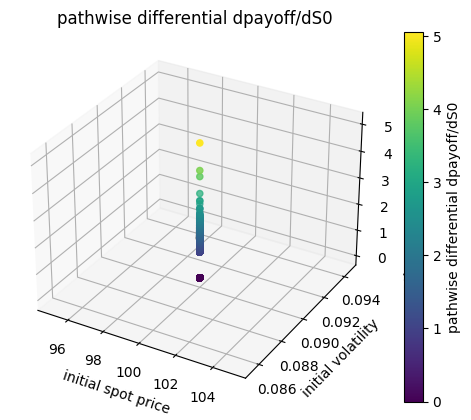

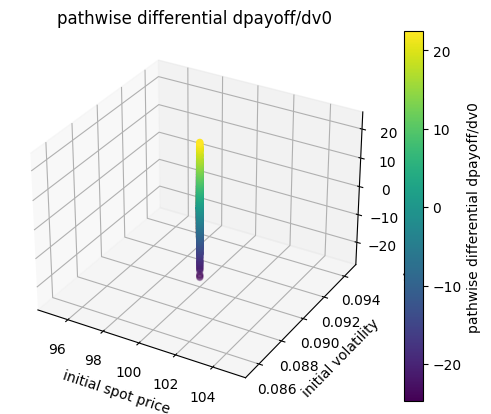

In [45]:
def plot_differential_data(init_spots, init_vols, payoffs, states: ModelState):
    # plt.plot(init_spots, payoffs, 'b.', markersize=1.0, label = 'payoffs')
    plt.plot(init_spots, states.S0, 'r.', markersize=1.0, label = 'dpayoff/dS0')

    print(init_spots.shape)
    print(states.S0.shape)
    # plt.plot(init_spots, states
    # plt.plot(hset.initial_spot_prices, prices, 'r.', markersize=3, label='price')
    plt.legend()
    plt.xlabel('initial spot price')
    plt.ylabel('payoff')
    # plt.ylim(-1, 1000)
    plt.show()

def plot_3d_differential_data(init_spots, init_vols, differential_data, label):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # ax.plot_trisurf(hset.initial_spot_prices, hset.initial_vols, prices, linewidth=0.2)
    sc = ax.scatter(init_spots, init_vols, differential_data, c=differential_data, cmap=plt.cm.viridis)
    
    # Add a colorbar to show the mapping of colors to z-values
    cbar = fig.colorbar(sc)
    cbar.set_label(label)
    
    ax.set_title(label)
    ax.set_xlabel("initial spot price")
    ax.set_ylabel("initial volatility")
    ax.set_zlabel(label)
    return fig

print("dpayoff/dS0")
fig = plot_3d_differential_data(initial_spots, initial_vols, dps.S0, "pathwise differential dpayoff/dS0")

print("dpayoff/dv0")
fig = plot_3d_differential_data(initial_spots, initial_vols, dps.v0, "pathwise differential dpayoff/dv0")